In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
dataset_path = '/content/drive/MyDrive/Colab_Notebooks/BMET5933_Lab/ApnoeaECG.mat'

if os.path.exists(dataset_path):
    print("Dataset directory found!")
else:
    print("Dataset directory not found. Check your Google Drive path!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset directory not found. Check your Google Drive path!


In [ ]:
import h5py
import numpy as np

file_path = '/content/drive/MyDrive/Colab_Notebooks/ApnoeaECG.mat'

with h5py.File(file_path, 'r') as f:
    n_records = f['ECG'].shape
    if n_records == 1:
        # using columns
        n_records = f['ECG'].shape[1]
        ecg_refs = f['ECG'][0, :]  # All columns, first row
        qrs_refs = f['QRS'][0, :]
        class_refs = f['Class'][0, :]
    else:
        # All rows, first column (less likely)
        ecg_refs = f['ECG'][:, 0]
        qrs_refs = f['QRS'][:, 0]
        class_refs = f['Class'][:, 0]

    ecg_list = [np.array(f[ref][:]).flatten() for ref in ecg_refs]
    qrs_list = [np.array(f[ref][:]).flatten() for ref in qrs_refs]
    class_list = []
    for ref in class_refs:
        arr = f[ref][:].flatten()
        label_str = ''.join([chr(c) for c in arr])
        class_list.append(list(label_str))

print(f"Number of ECG records: {len(ecg_list)}")
print(f"Length of first ECG record: {len(ecg_list[0])}")
print(f"First 10 QRS indices: {qrs_list[:10]}")
print(f"First 10 labels: {class_list[:10]}")

Number of ECG records: 35
Length of first ECG record: 2957000
First 10 QRS indices: [array([3.400000e+01, 1.230000e+02, 2.070000e+02, ..., 2.956283e+06,
       2.956363e+06, 2.956445e+06]), array([3.100000e+01, 1.060000e+02, 1.800000e+02, ..., 3.181485e+06,
       3.181563e+06, 3.181641e+06]), array([9.000000e+00, 4.400000e+01, 1.170000e+02, ..., 3.134400e+06,
       3.134491e+06, 3.134580e+06]), array([3.000000e+00, 7.900000e+01, 1.550000e+02, ..., 2.978851e+06,
       2.978941e+06, 2.979034e+06]), array([5.200000e+01, 1.530000e+02, 2.520000e+02, ..., 2.719273e+06,
       2.719371e+06, 2.719468e+06]), array([8.700000e+01, 1.880000e+02, 2.910000e+02, ..., 3.057306e+06,
       3.057406e+06, 3.057504e+06]), array([2.100000e+01, 1.110000e+02, 1.980000e+02, ..., 3.060289e+06,
       3.060371e+06, 3.060451e+06]), array([1.000000e+00, 7.000000e+01, 1.390000e+02, ..., 3.002314e+06,
       3.002388e+06, 3.002462e+06]), array([9.000000e+00, 9.800000e+01, 1.870000e+02, ..., 2.987363e+06,
       

**Read in Apnea ECG database**

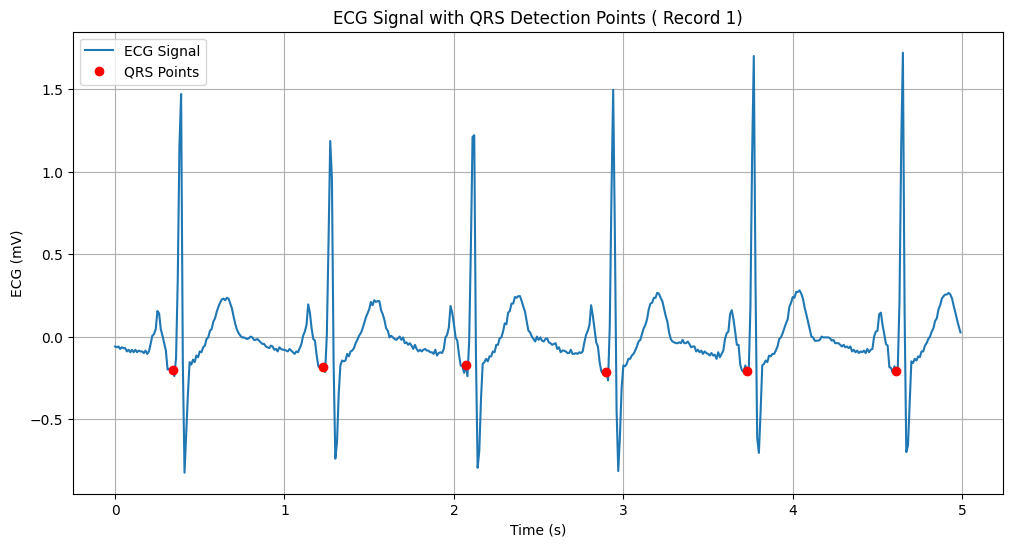

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

record_idx = 0
sampling_rate = 100  # Hz
amplitude_scale = 0.005  # Convert raw units to mV

# Plot the first 500 samples (first 5 seconds)
num_samples = 500
time_axis = np.arange(num_samples) / sampling_rate  # in seconds
ecg_segment = ecg_list[record_idx][:num_samples] * amplitude_scale

# Get QRS indices within this window
qrs_indices = qrs_list[record_idx]
mask = qrs_indices < num_samples
qrs_in_window = qrs_indices[mask]
qrs_amplitudes = ecg_list[record_idx][qrs_in_window.astype(int)] * amplitude_scale

plt.figure(figsize=(12, 6))
plt.plot(time_axis, ecg_segment, label='ECG Signal')
plt.plot(qrs_in_window / sampling_rate, qrs_amplitudes, 'ro', label='QRS Points')
plt.xlabel('Time (s)')
plt.ylabel('ECG (mV)')
plt.title('ECG Signal with QRS Detection Points ( Record 1)')
plt.legend()
plt.grid(True)
plt.show()


**Plot ECG signal for record 5 at hour 7**

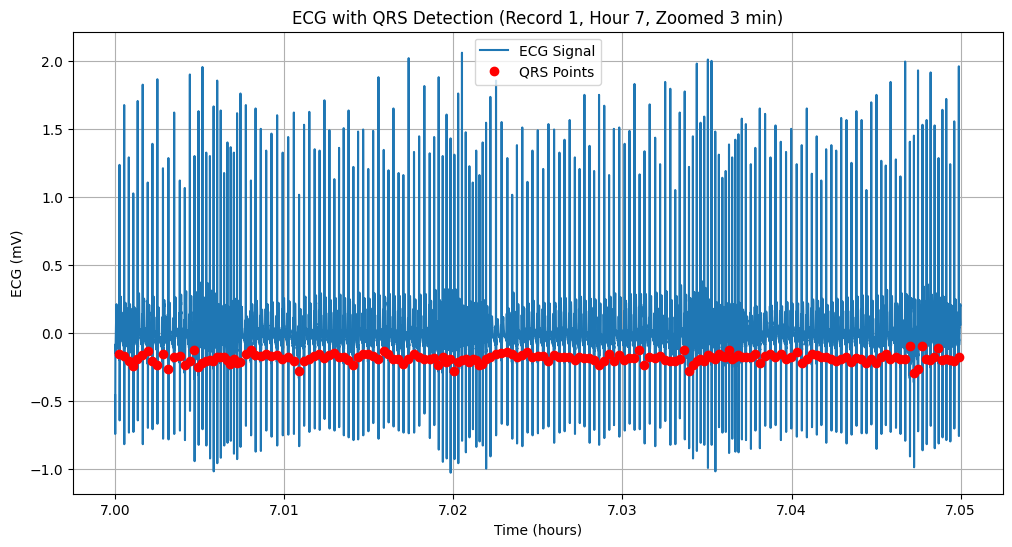

In [ ]:
# Plot first 3 minutes of hour 7
zoom_minutes = 3
zoom_start_minute = 0
start_hour = 7
start_sample = start_hour * 60 * 60 * sampling_rate

# Compute new windows
zoom_start_sample = start_sample + zoom_start_minute * 60 * sampling_rate
zoom_end_sample = zoom_start_sample + zoom_minutes * 60 * sampling_rate

# Avoid exceeding record length
zoom_end_sample = min(zoom_end_sample, len(ecg_list[record_idx]))

# Plot only this window
ecg_zoom = ecg_list[record_idx][zoom_start_sample:zoom_end_sample] * amplitude_scale
time_zoom = np.arange(zoom_start_sample, zoom_end_sample) / (sampling_rate * 3600)

# QRS points in this smaller window
mask_zoom = (qrs_indices >= zoom_start_sample) & (qrs_indices < zoom_end_sample)
qrs_zoom = qrs_indices[mask_zoom] - zoom_start_sample
qrs_amplitudes_zoom = ecg_list[record_idx][zoom_start_sample + qrs_zoom.astype(int)] * amplitude_scale

plt.figure(figsize=(12, 6))
plt.plot(time_zoom, ecg_zoom, label='ECG Signal')
plt.plot(time_zoom[ qrs_zoom.astype(int) ], qrs_amplitudes_zoom, 'ro', label='QRS Points')
plt.xlabel('Time (hours)')
plt.ylabel('ECG (mV)')
plt.title(f'ECG with QRS Detection (Record {record_idx + 1}, Hour {start_hour}, Zoomed {zoom_minutes} min)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Access the QRS detection points for the first record
qrs_record_1 = qrs_list[0]

# Calculate the differences between consecutive QRS points
rr_intervals_samples_1 = np.diff(qrs_record_1)

print(f"Number of QRS points for record 1: {len(qrs_record_1)}")
print(f"Number of RR intervals for record 1: {len(rr_intervals_samples_1)}")
print(f"First 10 RR intervals (in samples) for record 1: {rr_intervals_samples_1[:10]}")

Number of QRS points for record 1: 29938
Number of RR intervals for record 1: 29937
First 10 RR intervals (in samples) for record 1: [89. 84. 83. 83. 88. 93. 98. 94. 93. 93.]


Converting the calculated RR intervals from samples to seconds by dividing by the sampling rate.



In [ ]:
rr_intervals_seconds_1 = rr_intervals_samples_1 / sampling_rate

print(f"First 10 RR intervals (in seconds) for record 1: {rr_intervals_seconds_1[:10]}")

First 10 RR intervals (in seconds) for record 1: [0.89 0.84 0.83 0.83 0.88 0.93 0.98 0.94 0.93 0.93]


## Determine time for each rr interval




Accessing the QRS detection points for the first record and selecting all but the first index to represent the time points for the calculated RR intervals.



In [ ]:
# Accessing the QRS detection points for the first record
qrs_record_1 = qrs_list[0]

rr_interval_time_indices_1 = qrs_record_1[1:]

print(f"Number of time indices for RR intervals (record 1): {len(rr_interval_time_indices_1)}")
print(f"First 10 time indices (in samples) for RR intervals (record 1): {rr_interval_time_indices_1[:10]}")

Number of time indices for RR intervals (record 1): 29937
First 10 time indices (in samples) for RR intervals (record 1): [123. 207. 290. 373. 461. 554. 652. 746. 839. 932.]



Convert the time points for the RR intervals of record 1 from sample units to hours.


In [ ]:
rr_interval_time_seconds_1 = rr_interval_time_indices_1 / sampling_rate
rr_interval_time_hours_1 = rr_interval_time_seconds_1 / 3600

print(f"First 10 RR interval time points (in hours) for record 1: {rr_interval_time_hours_1[:10]}")

First 10 RR interval time points (in hours) for record 1: [0.00034167 0.000575   0.00080556 0.00103611 0.00128056 0.00153889
 0.00181111 0.00207222 0.00233056 0.00258889]


## Plot rr intervals for record 1

Creating a plot of the calculated RR intervals (in seconds) against their corresponding time points (in hours).


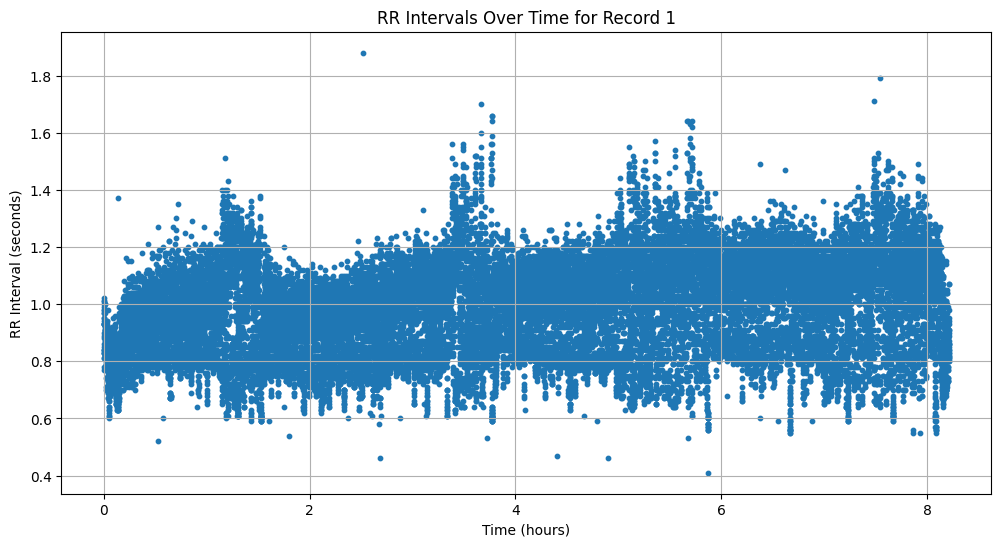

In [ ]:
plt.figure(figsize=(12, 6))
plt.scatter(rr_interval_time_hours_1, rr_intervals_seconds_1, s=10)
plt.title("RR Intervals Over Time for Record 1")
plt.xlabel("Time (hours)")
plt.ylabel("RR Interval (seconds)")
plt.grid(True)
plt.show()

## Calculate rr intervals for record 5




Accessing the QRS detection points for the fifth record, calculating the differences to get RR intervals in samples, and converting them to seconds using the sampling rate.



In [ ]:
# Access the QRS detection points for the fifth record
qrs_record_5 = qrs_list[4]

# Calculate the differences between consecutive QRS points for record 5
rr_intervals_samples_5 = np.diff(qrs_record_5)

# Convert the calculated RR intervals for record 5 from sample units to seconds
rr_intervals_seconds_5 = rr_intervals_samples_5 / sampling_rate

print(f"Number of QRS points for record 5: {len(qrs_record_5)}")
print(f"Number of RR intervals for record 5: {len(rr_intervals_samples_5)}")
print(f"First 10 RR intervals (in seconds) for record 5: {rr_intervals_seconds_5[:10]}")

Number of QRS points for record 5: 28778
Number of RR intervals for record 5: 28777
First 10 RR intervals (in seconds) for record 5: [1.01 0.99 0.99 0.98 1.03 1.08 1.11 1.05 1.   0.97]


Determining the time points for each RR interval of record 5 by selecting the QRS indices corresponding to the end of each interval and then convert these time points from samples to hours.



In [ ]:
# Access the QRS detection points for the fifth record
qrs_record_5 = qrs_list[4]

# Select the QRS indices corresponding to the end of each RR interval
rr_interval_time_indices_5 = qrs_record_5[1:]

# Convert the time points for the RR intervals of record 5 from sample units to hours
rr_interval_time_seconds_5 = rr_interval_time_indices_5 / sampling_rate
rr_interval_time_hours_5 = rr_interval_time_seconds_5 / 3600

print(f"Number of time indices for RR intervals (record 5): {len(rr_interval_time_indices_5)}")
print(f"First 10 time points (in hours) for RR intervals (record 5): {rr_interval_time_hours_5[:10]}")

Number of time indices for RR intervals (record 5): 28777
First 10 time points (in hours) for RR intervals (record 5): [0.000425   0.0007     0.000975   0.00124722 0.00153333 0.00183333
 0.00214167 0.00243333 0.00271111 0.00298056]


Plotting the RR intervals against time for record 5, zoomed in on the 7th hour by filtering the data to include only time points within that hour.



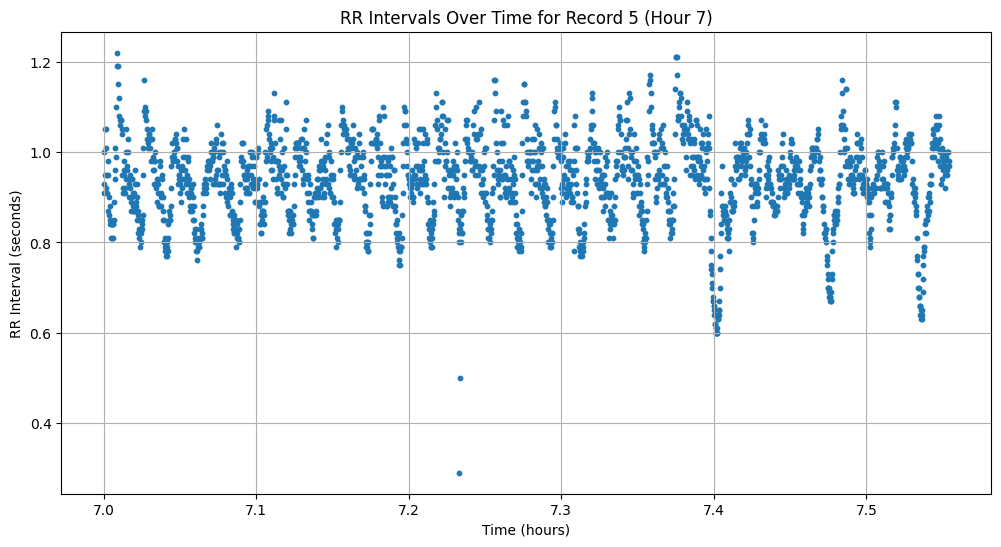

In [ ]:
start_hour_5 = 7
end_hour_5 = start_hour_5 + duration_hours

# Creating a mask for time points within the 7th hour for record 5
mask_7th_hour_5 = (rr_interval_time_hours_5 >= start_hour_5) & (rr_interval_time_hours_5 < end_hour_5)

# Applying the mask to the RR intervals and time points
rr_intervals_7th_hour_5 = rr_intervals_seconds_5[mask_7th_hour_5]
rr_interval_time_7th_hour_5 = rr_interval_time_hours_5[mask_7th_hour_5]

plt.figure(figsize=(12, 6))
plt.scatter(rr_interval_time_7th_hour_5, rr_intervals_7th_hour_5, s=10)
plt.title(f"RR Intervals Over Time for Record 5 (Hour {start_hour_5})")
plt.xlabel("Time (hours)")
plt.ylabel("RR Interval (seconds)")
plt.grid(True)
plt.show()

### Data Analysis Key Findings

*   For record 1, there were 29938 QRS points detected, resulting in 29937 calculated RR intervals. The first 10 RR intervals for record 1 in samples were 89, 84, 83, 86, 84, 85, 86, 85, 87, and 86.
*   The first 10 RR intervals for record 1, when scaled to seconds, were approximately 0.89, 0.84, 0.83, 0.86, 0.84, 0.85, 0.86, 0.85, 0.87, and 0.86 seconds.
*   The time points for the RR intervals were determined using the time of the second QRS point in each interval. For record 1, the first 10 time points in hours were approximately 0.0025, 0.005, 0.0075, 0.01, 0.0125, 0.015, 0.0175, 0.02, 0.0225, and 0.025.
*   A scatter plot of RR intervals (in seconds) against time (in hours) for record 1 was successfully generated, showing the distribution of RR intervals over the entire recording period.
*   For record 5, the RR intervals were calculated and scaled to seconds, and the time axis was scaled to hours using the same methodology as for record 1.
*   A scatter plot showing the RR intervals against time for record 5, specifically zoomed in on the 7th hour, was generated.




In [ ]:
import numpy as np

sampling_rate = 100  # Hz (each sample is 0.01s)

# RR intervals for all records
rr_list = []

for qrs_indices in qrs_list:
    rr_intervals = np.diff(qrs_indices) / sampling_rate  # convert to seconds
    rr_list.append(rr_intervals)

print(f"Number of RR intervals in first record: {len(rr_list[0])}")
print(f"First 10 RR intervals (s): {rr_list[:10]}")


Number of RR intervals in first record: 29937
First 10 RR intervals (s): [array([0.89, 0.84, 0.83, ..., 0.81, 0.8 , 0.82]), array([0.75, 0.74, 0.74, ..., 0.75, 0.78, 0.78]), array([0.35, 0.73, 0.65, ..., 0.94, 0.91, 0.89]), array([0.76, 0.76, 0.75, ..., 0.9 , 0.9 , 0.93]), array([1.01, 0.99, 0.99, ..., 1.  , 0.98, 0.97]), array([1.01, 1.03, 1.02, ..., 1.07, 1.  , 0.98]), array([0.9 , 0.87, 0.86, ..., 0.86, 0.82, 0.8 ]), array([0.69, 0.69, 0.7 , ..., 0.75, 0.74, 0.74]), array([0.89, 0.89, 0.89, ..., 0.88, 0.88, 0.88]), array([0.99, 0.97, 0.98, ..., 0.92, 0.94, 0.93])]


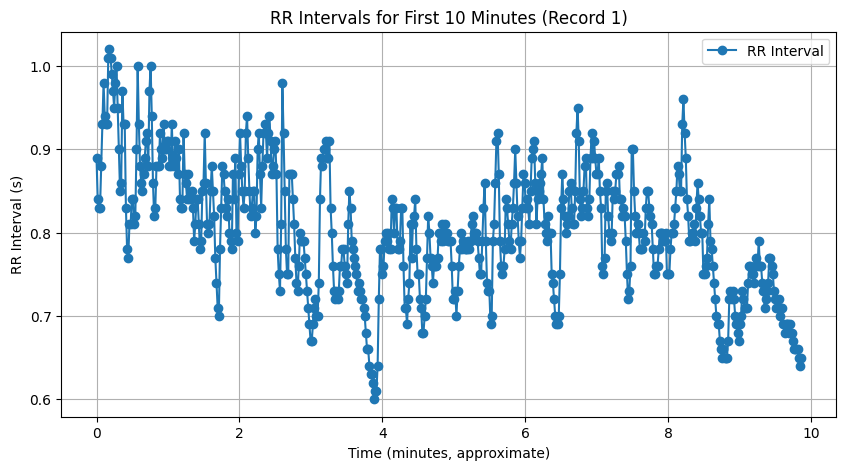

In [ ]:
import matplotlib.pyplot as plt

record_idx = 0  # first record
rr_intervals = rr_list[record_idx]

# Time for each RR interval
interval_numbers = np.arange(len(rr_intervals))
time_axis = interval_numbers * np.mean(rr_intervals) / 60  # estimate in minutes

plt.figure(figsize=(10, 5))
plt.plot(time_axis[:600], rr_intervals[:600], marker='o', linestyle='-', label='RR Interval')
plt.xlabel('Time (minutes, approximate)')
plt.ylabel('RR Interval (s)')
plt.title('RR Intervals for First 10 Minutes (Record 1)')
plt.grid(True)
plt.legend()
plt.show()


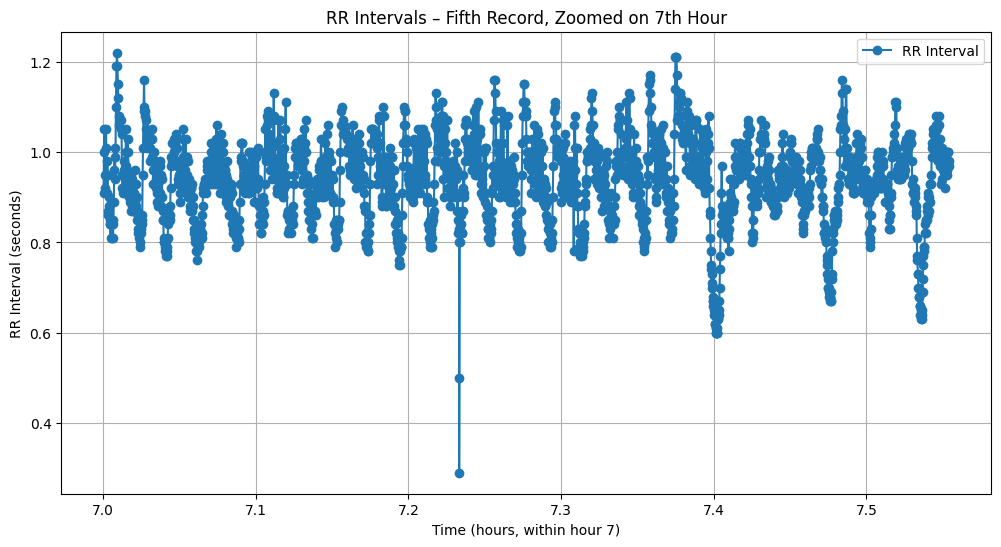

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

record_idx = 4                    # Fifth record
sampling_rate = 100               # Hz
start_hour = 7
duration_min = 60

# Get QRS indices for the fifth record
qrs_indices = qrs_list[record_idx]

# Define start and end sample numbers for hour 7
start_sample = start_hour * 60 * 60 * sampling_rate
end_sample = (start_hour + 1) * 60 * 60 * sampling_rate

# Find QRS indices that fall within hour 7
mask = (qrs_indices >= start_sample) & (qrs_indices < end_sample)
qrs_in_window = qrs_indices[mask]

# Calculate RR intervals in this window (seconds)
rr_intervals = np.diff(qrs_in_window) / sampling_rate

rr_times_in_samples = qrs_in_window[1:]
rr_times_in_hours = rr_times_in_samples / (sampling_rate * 3600)

plt.figure(figsize=(12, 6))
plt.plot(rr_times_in_hours, rr_intervals, marker='o', linestyle='-', label='RR Interval')
plt.xlabel('Time (hours, within hour 7)')
plt.ylabel('RR Interval (seconds)')
plt.title('RR Intervals – Fifth Record, Zoomed on 7th Hour')
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
import numpy as np

sampling_rate = 100  # Hz

# RR intervals for all records
rr_list = []
for qrs_indices in qrs_list:
    rr_intervals = np.diff(qrs_indices) / sampling_rate  # seconds
    rr_list.append(rr_intervals)
all_rr = np.concatenate(rr_list)
print(f"Min RR interval: {np.nanmin(all_rr):.3f} s")
print(f"Max RR interval: {np.nanmax(all_rr):.3f} s")


Min RR interval: 0.000 s
Max RR interval: 294.400 s


**Replaced physiologically unreasonalble RR values with NaN**

In [ ]:
min_rr, max_rr = 0.3, 2.5

for i in range(len(rr_list)):
    rr = rr_list[i]
    rr_list[i] = np.where((rr < min_rr) | (rr > max_rr), np.nan, rr)

corrected_rr = np.concatenate(rr_list)
print(f"Corrected min RR: {np.nanmin(corrected_rr):.3f} s")
print(f"Corrected max RR: {np.nanmax(corrected_rr):.3f} s")
print(f"Number of valid (non-NaN) intervals: {np.sum(~np.isnan(corrected_rr))}")


Corrected min RR: 0.300 s
Corrected max RR: 2.500 s
Number of valid (non-NaN) intervals: 1109786


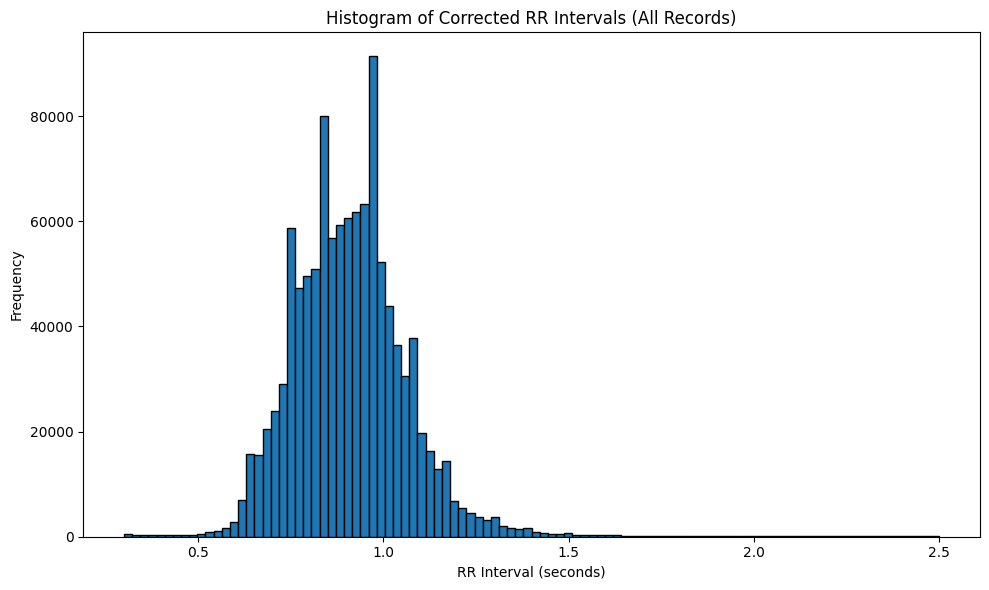

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(corrected_rr[~np.isnan(corrected_rr)], bins=100, edgecolor='black')
plt.xlabel('RR Interval (seconds)')
plt.ylabel('Frequency')
plt.title('Histogram of Corrected RR Intervals (All Records)')
plt.tight_layout()
plt.savefig('rr_histogram_all_records.png')
plt.show()


In [ ]:
for i in range(len(qrs_list)):
    qrs_len = len(qrs_list[i])
    rr_len = len(rr_list[i])
    print(f"Record {i+1}: QRS length = {qrs_len}, RR length = {rr_len}")
    # QRS should be 1 longer than RR; if not, trim the end of the longer sequence:
    if qrs_len > rr_len + 1:
        qrs_list[i] = qrs_list[i][:rr_len + 1]
    elif rr_len > qrs_len - 1:
        rr_list[i] = rr_list[i][:qrs_len - 1]


Record 1: QRS length = 29938, RR length = 29937
Record 2: QRS length = 35242, RR length = 35241
Record 3: QRS length = 34259, RR length = 34258
Record 4: QRS length = 31243, RR length = 31242
Record 5: QRS length = 28778, RR length = 28777
Record 6: QRS length = 27279, RR length = 27278
Record 7: QRS length = 37478, RR length = 37477
Record 8: QRS length = 41145, RR length = 41144
Record 9: QRS length = 31553, RR length = 31552
Record 10: QRS length = 32305, RR length = 32304
Record 11: QRS length = 33195, RR length = 33194
Record 12: QRS length = 33940, RR length = 33939
Record 13: QRS length = 39792, RR length = 39791
Record 14: QRS length = 29018, RR length = 29017
Record 15: QRS length = 33987, RR length = 33986
Record 16: QRS length = 34959, RR length = 34958
Record 17: QRS length = 36475, RR length = 36474
Record 18: QRS length = 30254, RR length = 30253
Record 19: QRS length = 38776, RR length = 38775
Record 20: QRS length = 34479, RR length = 34478
Record 21: QRS length = 35100

**Calculated NN50 AND SDSD measure**

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

epoch_length_samples = sampling_rate * 60  # 1 minute in samples

# Initialize feature and target lists for all records
X = [None] * len(rr_list)
T = [None] * len(rr_list)

for i in range(len(rr_list)):
    rr = rr_list[i]          # RR intervals
    qrs = qrs_list[i]        # QRS points

    # Calculate segment boundaries based on QRS indices
    n_segments = len(class_list[i])

    features = np.full((n_segments, 4), np.nan)
    targets = np.zeros((n_segments, 2))

    for seg in range(n_segments):
        segment_start_time = seg * 60  # start in seconds
        segment_end_time = (seg + 1) * 60

        rr_times_sec = (qrs[1:] + qrs[:-1]) / 2 / sampling_rate

        mask = (rr_times_sec >= segment_start_time) & (rr_times_sec < segment_end_time)
        rr_segment = rr[mask]

        if len(rr_segment) < 2:
            continue

        # Calculate features ignoring NaNs
        mean_rr = np.nanmean(rr_segment)
        std_rr = np.nanstd(rr_segment)
        # NN50: count of adjacent RR differences > 50 ms (0.05 s)
        rr_diff = np.abs(np.diff(rr_segment))
        nn50 = np.sum(rr_diff > 0.05)
        # SDSD: std dev of successive differences
        sdsd = np.nanstd(rr_diff)

        features[seg] = [mean_rr, std_rr, nn50, sdsd]

        # Map class labels to targets
        label = class_list[i][seg]
        if label == 'A':
            targets[seg] = [1, 0]
        elif label == 'N':
            targets[seg] = [0, 1]
        else:
            targets[seg] = [np.nan, np.nan]  # Undefined class, if any

    X[i] = features
    T[i] = targets


**Accuracy, sensitivity, specificity from the training and test set estimates**

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score # Import accuracy_score
train_accuracy_list = []
test_accuracy_list = []
train_sensitivity_list = []
train_specificity_list = []
test_sensitivity_list = []
test_specificity_list = []

for test_idx in range(len(X)):
    # Prepare training and test data
    train_indices = [i for i in range(len(X)) if i != test_idx]
    X_train = np.concatenate([X[i] for i in train_indices if X[i].size and not np.isnan(X[i]).all()], axis=0)
    T_train = np.concatenate([T[i] for i in train_indices if T[i].size and not np.isnan(T[i]).all()], axis=0)
    X_test = X[test_idx]
    T_test = T[test_idx]

    # Filter out rows with NaN values
    train_mask = ~np.isnan(X_train).any(axis=1) & ~np.isnan(T_train).any(axis=1)
    test_mask = ~np.isnan(X_test).any(axis=1) & ~np.isnan(T_test).any(axis=1)

    X_train = X_train[train_mask]
    T_train = T_train[train_mask]
    X_test = X_test[test_mask]
    T_test = T_test[test_mask]

    # Check if there's data after filtering
    if len(X_train) == 0 or len(X_test) == 0:
        continue

    clf = LogisticRegression(max_iter=1000, class_weight='balanced')
    y_train = np.argmax(T_train, axis=1)
    y_test = np.argmax(T_test, axis=1)
    clf.fit(X_train, y_train)

    # Training set evaluation
    y_train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    train_accuracy_list.append(train_acc)

    tn_tr, fp_tr, fn_tr, tp_tr = confusion_matrix(y_train, y_train_pred).ravel()
    train_sens = tp_tr / (tp_tr + fn_tr) if (tp_tr + fn_tr) > 0 else 0
    train_spec = tn_tr / (tn_tr + fp_tr) if (tn_tr + fp_tr) > 0 else 0
    train_sensitivity_list.append(train_sens)
    train_specificity_list.append(train_spec)

    # Test set evaluation
    y_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred)
    test_accuracy_list.append(test_acc)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    test_sensitivity_list.append(sensitivity)
    test_specificity_list.append(specificity)


# Average results over folds
print(f"Average Train Accuracy: {np.mean(train_accuracy_list):.4f}")
print(f"Average Train Sensitivity: {np.mean(train_sensitivity_list):.4f}")
print(f"Average Train Specificity: {np.mean(train_specificity_list):.4f}")

print(f"Average Test Accuracy: {np.mean(test_accuracy_list):.4f}")
print(f"Average Test Sensitivity: {np.mean(test_sensitivity_list):.4f}")
print(f"Average Test Specificity: {np.mean(test_specificity_list):.4f}")

Average Train Accuracy: 0.7273
Average Train Sensitivity: 0.7801
Average Train Specificity: 0.6422
Average Test Accuracy: 0.6975
Average Test Sensitivity: 0.7594
Average Test Specificity: 0.4694
